<a href="https://colab.research.google.com/github/AraiKensuke/FitSpectrum/blob/master/FitPowerSpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nitime


#@title Install LOST { form-width: "20%" }
import sys
import importlib

if importlib.util.find_spec("FitSpectrum") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/FitSpectrum.git
  %cd /content/LOST

#!python setup.py build_ext --inplace   #  don't need to compile for this notebook

sys.path.insert(1, "/content/LOST")    #  add these to searchpath for python modules



     |████████████████████████████████| 6.2MB 5.2MB/s 
  Created wheel for nitime: filename=nitime-0.9-cp37-cp37m-linux_x86_64.whl size=4032114 sha256=3b38e550288a834716d2f7f726df37ab410d4cdfe72f585bfc63baa09524431d
  Stored in directory: /root/.cache/pip/wheels/9d/d6/a7/ecbf971b5b91880cbba499bb10d949e84266f24396a916ddb5
Successfully built nitime


Routines to create an oscillating signal with some spectral width, ie a signal whose instantaneous period fluctuates.

In [ ]:
# create the signal
import numpy.polynomial.polynomial as _Npp
import numpy as np
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate

####  Ken's build_signal   - allow for more variable oscillations.
####  neural oscillations aren't sinusoids, rather their periods
####  fluctuate.  Use AR(2) 
def build_signal(N, dt, comps, wgts):
    obsvd = np.zeros(N)
    ic = -1

    for comp in comps:
        ic += 1
        r_comp = comp[1]
        osc_comp = comp[0]

        l_alfa = []
        for thr in osc_comp:
            r = thr[1]
            hz= thr[0]
            th = 2*hz*dt

            l_alfa.append(r*(np.cos(np.pi*th) + 1j*np.sin(np.pi*th)))
            l_alfa.append(r*(np.cos(np.pi*th) - 1j*np.sin(np.pi*th)))
        for r in r_comp:
            l_alfa.append(r)

        alfa  = np.array(l_alfa)
        ARcoeff          = (-1*_Npp.polyfromroots(alfa)[::-1][1:]).real
        sgnlC, y = createDataAR(N, ARcoeff, 0.01, 0)
        obsvd += wgts[ic] * sgnlC

    return obsvd / np.std(obsvd)


def createDataAR(N, B, err, obsnz, trim=0):
    #  a[1]^2 + 4a[0]
    #  B[0] = -0.45
    #  B[1] =  0.9
    err = np.sqrt(err)
    obsnz  = np.sqrt(obsnz)
    p = len(B)
    BB = np.array(B[::-1])   #  B backwards

    x    = np.empty(N)
    y    = np.empty(N)

    #  initial few
    for i in range(p+1):
        x[i] = err*np.random.randn()
        y[i] = obsnz*np.random.randn()

    nzs = err*np.random.randn(N)
    for i in range(p+1, N):
        #x[i] = _N.dot(B, x[i-1:i-p-1:-1]) + nzs[i]
        x[i] = np.dot(BB, x[i-p:i]) + nzs[i]
        #  y = Hx + w   where w is a zero-mean Gaussian with cov. matrix R.
        #  In our case, H is 1 and R is 1x1
    onzs = obsnz*np.random.randn(N)
    y[p+1:N] = x[p+1:N] + onzs[p+1:N]

    return x[trim:N], y[trim:N]

First, let's see what short time MT powerspec of a very tight oscillation looks like:

---



(1.0, 55.0)

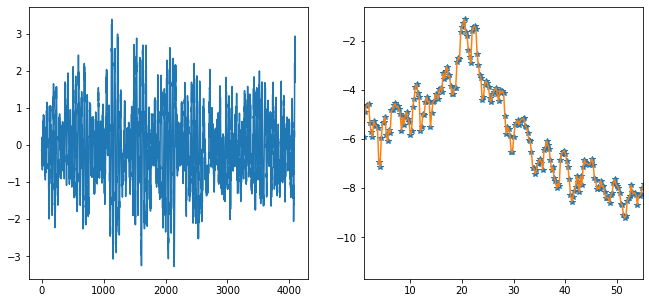

In [ ]:
np.random.seed(1000)   #  set the random seed.

###  Specify the signal 
f1=21.   # hz
coh1=0.99   # how coherent or sinusoidal is f1 osc?  0~1    1 near sinusoidal, > 0.95 neural-like

obs_nz    = 0.25   #  make this bigger to add more observation noise
#  comps = [[    [freq1, coh1], [freq2, coh2]...,   [(non-periodic component 1    0~1), (non-periodic component 2    0~1)....]
comps         = [[[f1, coh1]], []]      #  describe AR(p) in terms of AR(2) and AR(1) components.
N             = 4096    #  number of data points in timeseries
dt            = 0.001   #  in seconds.  0.001 is 1ms.
#  
signal         = build_signal(N, dt, [comps], [1])  
signal         += obs_nz*np.random.randn(N)    #  add observation noise (white noise)


fig = plt.figure(figsize=(11, 5))
fig.add_subplot(1, 2, 1)
plt.plot(signal)
fig.add_subplot(1, 2, 2)
# multi-taper: for now, let's work on the average of tapers
# focus on 1 to 30 Hz
bw = 2
f, psd_mt, nu = tsa.multi_taper_psd(signal,Fs=1/dt, NW=bw , low_bias=False, adaptive=False, jackknife=False)
plt.plot(f,np.log(psd_mt),'*')
plt.plot(f,np.log(psd_mt))
plt.xlim(1,55)

MT powerspec for a tight oscillation

(1.0, 55.0)

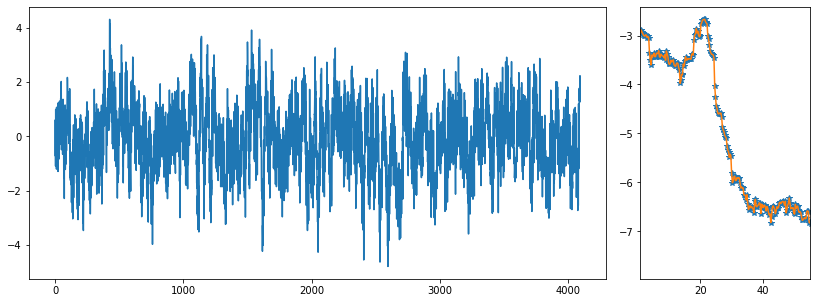

In [ ]:
np.random.seed(1000)   #  set the random seed.

###  Specify the signal 
f1=21.   # hz
coh1=0.982   # how coherent or sinusoidal is f1 osc?  0~1    1 near sinusoidal, > 0.95 neural-like

obs_nz    = 0.8   #  make this bigger to add more observation noise
comps         = [[[f1, coh1]], [0.96]]      #  describe AR(p) in terms of AR(2) and AR(1) components.
N             = 4096
dt            = 0.001
#  
signal         = build_signal(N, dt, [comps], [1])  
signal         += obs_nz*np.random.randn(N)    #  add observation noise (white noise)


fig = plt.figure(figsize=(14, 5))
plt.subplot2grid((1, 4), (0, 0), colspan=3)
plt.plot(signal)
plt.subplot2grid((1, 4), (0, 3), colspan=1)
# multi-taper: for now, let's work on the average of tapers
# focus on 1 to 30 Hz
bw = 9
f, psd_mt, nu = tsa.multi_taper_psd(signal,Fs=1/dt, NW=bw , low_bias=False, adaptive=False, jackknife=False)
plt.plot(f,np.log(psd_mt),'*')
plt.plot(f,np.log(psd_mt))
plt.xlim(1,55)

In [ ]:
import pymc3 as pm
import numpy as _N
import matplotlib.pyplot as plt; plt.ion()

theseInds = _N.where(f < 55)[0]

f_psd     = f[theseInds]

# # define the model/function to be fitted.

with pm.Model() as model3:
    #amp = pm.Uniform('amp', 0.05, 0.4, testval= 0.15)
    amp1 = pm.HalfNormal('amp1', sigma=1)
    amp2 = pm.HalfNormal('amp2', sigma=1)
    amp3 = pm.HalfNormal('amp3', sigma=1)
    #size = pm.Uniform('size', 0.1, 2.5, testval= 1.0)
    width1 = pm.HalfNormal('width1', sigma=2)
    width2 = pm.HalfNormal('width2', sigma=2)
    width3= pm.HalfNormal('width3', sigma=2)
    mu1 = pm.Normal('mu1', mu=1, sigma=5)   #  initialize w/ diff values
    mu2 = pm.Normal('mu2', mu=15, sigma=5)
    mu3 = pm.Normal('mu3', mu=30, sigma=5)
    a = pm.Normal('a', 0.13, 40)
    b = pm.Normal('b', 0.13, 40)

    error = pm.HalfNormal("error", sigma=0.3)
    gauss=pm.Deterministic('gauss',amp1*_N.exp(-0.5*(f_psd-mu1)**2/(width1**2))+amp2*_N.exp(-0.5*(f_psd-mu2)**2/(width2**2))+amp3*_N.exp(-0.5*(f_psd-mu3)**2/(width3**2))+a/(f_psd+b))

    #y =pm.Normal('y', mu=gauss, tau=1.0/f_error**2, observed=f)
    y =pm.Normal('y', mu=gauss, sigma=error, observed=np.log(psd_mt[theseInds]))

    #map_estimate=pm.find_MAP()
    step=pm.NUTS()
    trace=pm.sample(2000)

# # extract and plot results
# y_min = _N.percentile(trace.gauss,2.5,axis=0)
# y_max = _N.percentile(trace.gauss,97.5,axis=0)
# y_fit = _N.percentile(trace.gauss,50,axis=0)
# plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
# plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
# plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
# plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
# plt.legend()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, b, a, mu3, mu2, mu1, width3, width2, width1, amp3, amp2, amp1]
100%|██████████| 2500/2500 [03:05<00:00, 13.47it/s]
The acceptance probability does not match the target. It is 0.9839376162112976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9602145273942566, but should be close to 0.8. Try to increase the number of tuning steps.


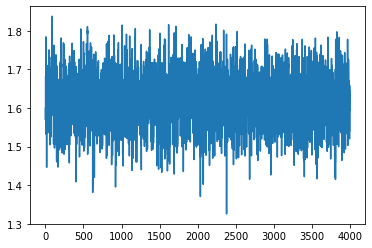

In [ ]:
plt.plot(trace.amp3)

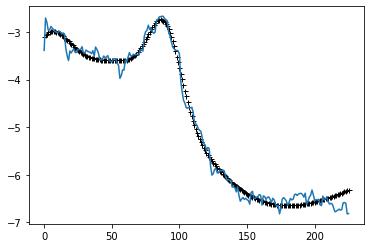

In [ ]:
y_fit = _N.percentile(trace.gauss,50,axis=0)
plt.plot(y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(np.log(psd_mt[theseInds]))

In [ ]:
import arviz as az

ModuleNotFoundError: ignored

In [ ]:
!pip install arviz==0.10.0

     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 4.7MB 18.4MB/s 
     |████████████████████████████████| 768kB 49.0MB/s 
     |████████████████████████████████| 317kB 45.3MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [ ]:
import arviz as az
with model3:
    az.plot_trace(trace);

AttributeError: ignored

In [ ]:
az.__version__

'0.10.0'

In [ ]:
pm.__version__


'3.7'